In [1]:
# basic
import copy
import math
import os
import random
import time
from tqdm import tqdm

# viz
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# data
import numpy as np
import pandas as pd
from PIL import Image

# torch
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import WeightedRandomSampler

# lib
from dataset import XRayDataset
import utils

## Check GPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Config vars

In [3]:
root = '.'
metadata_path = os.path.join(root, 'Chest_xray_Corona_Metadata.csv') 
dataset_path = os.path.join(root, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
test_dataset_path = os.path.join(dataset_path, 'test')
model_store_path = os.path.join(root, 'models')

#backbone_model = 'resnet18'
backbone_model = 'mobilenet_v2'

target_labels = ['Normal', 'Pnemonia']

# create a map for label->id
label_id_map = {}
id_label_map = {}

for i in range(0 , len(target_labels)):
    label_id_map[target_labels[i]] = i
    id_label_map[i] = target_labels[i]

In [4]:
label_id_map

{'Normal': 0, 'Pnemonia': 1}

## Utility Functions

In [5]:
def plot_images(imgs, targets):
        
    num_plots = len(imgs)
    
    # define rows and cols
    cols = 4
    rows = (num_plots // cols) + 1
    
    # create figure
    fig = plt.figure(figsize=(10, 7))
    fig.tight_layout()
    
    for i in range(num_plots):
        
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, cols, i+1)
        plt.subplots_adjust(left=0.01, bottom=None, right=None, top=None, wspace=None, hspace=None)

        # showing image
        plt.imshow(imgs[i].permute(1, 2, 0))
        plt.axis('off')
        #plt.title(f"{targets[i]['label_1']}, {targets[i]['label_2']}, {targets[i]['label_3']}")
        label_id = int(targets[i]['label_1'])
        plt.title(f"{id_label_map[label_id]}")

In [6]:
def get_transform(train):
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    #transforms.Normalize([0.5], [0.5])
    
    return transform

In [7]:
def get_model(num_classes):
    
    if backbone_model == 'resnet18':
        model = torchvision.models.resnet18(pretrained=True)
        # reasssign last layer with output units changed
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    if backbone_model == 'mobilenet_v2':
        model = torchvision.models.mobilenet_v2(pretrained=True)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)    
    
    return model

In [8]:
def train_model(model, dataloader_train, dataloader_val, criterion, optimizer, dataset_sizes, scheduler=None, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                running_loss = 0.0
                running_corrects = 0

                for inputs, targets in dataloader_train:
                    inputs = torch.cat([img.unsqueeze(0) for img in inputs], dim=0).to(device)  
                    labels = torch.as_tensor([target['label_1'] for target in targets]).to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        #print(f'outputs: {outputs}')
                        #print(f'labels: {labels}')
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                            
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
                    
            else:
                model.eval()   # Set model to evaluate mode
                
                running_loss = 0.0
                running_corrects = 0

                for inputs, targets in dataloader_val:
                    inputs = torch.cat([img.unsqueeze(0) for img in inputs], dim=0).to(device)  
                    labels = torch.as_tensor([target['label_1'] for target in targets]).to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                            
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
                
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60}m {time_elapsed}s')
    print(f'Best val Acc: {best_acc}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
                

## Plot few samples from dataset

dataset length: 5286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


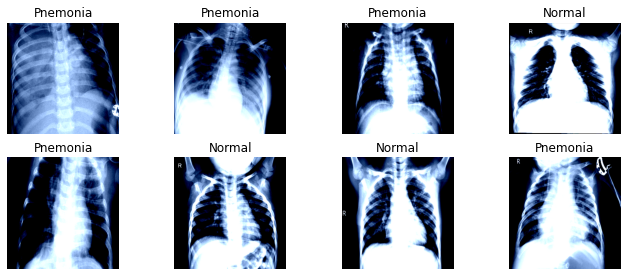

In [9]:
dataset = XRayDataset(mode='train', dataset_path=dataset_path, metadata_path=metadata_path, transforms=get_transform(train=True))
train_set_length = len(dataset)
print(f'dataset length: {train_set_length}')
num_samples = 8
imgs = []
targets = []
for i in range(num_samples):
    random_idx = random.randrange(0, train_set_length)
    img, target = dataset[random_idx]
    imgs.append(img)
    targets.append(target)
    #print(f'img shape: {img.size()}')
    #print(f'target: {target}')
plot_images(imgs, targets)

## TODO: Use WeightedRandomSampler to handle the class imbalances

In [10]:
# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights,
#     num_samples=len(class_weights),
#     replacement=True
# )

## Instantiate the train and val dataloaders


In [11]:
val_split_ratio = 0.1

# later see if you can have train-specific transforms
train_dataset = XRayDataset(mode='train', dataset_path=dataset_path, metadata_path=metadata_path, transforms=get_transform(train=True))
val_dataset = XRayDataset(mode='train', dataset_path=dataset_path, metadata_path=metadata_path, transforms=get_transform(train=False))

# split dataset in train and val set
train_dataset_len = len(train_dataset)
indices = torch.randperm(train_dataset_len).tolist()
val_split_index = int(val_split_ratio * train_dataset_len)
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-1 * val_split_index])
val_dataset = torch.utils.data.Subset(val_dataset, indices[-1 * val_split_index:])

# define the dataloaders
dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
#sampler=weighted_sampler

dataloader_val = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

dataset_sizes = {
    'train' : len(train_dataset),
    'val' : len(val_dataset)
}

print(f'train indices: 0 to {train_dataset_len - val_split_index}\nval indices: {train_dataset_len - val_split_index} to {train_dataset_len}\n')
print(f'dataset_sizes : {dataset_sizes}')


train indices: 0 to 4758
val indices: 4758 to 5286

dataset_sizes : {'train': 4758, 'val': 528}


## Model config

In [12]:
num_classes = len(target_labels)
model = get_model(num_classes).to(device)

df_metadata = pd.read_csv(metadata_path)
weight_distrbution = torch.as_tensor([item/len(df_metadata) for item in df_metadata['Label'].value_counts()])

# passing the weight distribution vector to the loss function because classes are slightly imbalanced
criterion = nn.CrossEntropyLoss(weight=weight_distrbution.to(device))
#criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

## Train

In [14]:
model = train_model(model, dataloader_train, dataloader_val, criterion, optimizer, dataset_sizes, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3615771930160485 Acc: 0.8808322824716267
val Loss: 0.09209557686808419 Acc: 0.9715909090909092
Epoch 1/9
----------
train Loss: 0.11192087113274461 Acc: 0.9590163934426229
val Loss: 0.3327264199390598 Acc: 0.8901515151515151
Epoch 2/9
----------
train Loss: 0.08426734609776862 Acc: 0.9712063892391761
val Loss: 0.05915572521915678 Acc: 0.975378787878788
Epoch 3/9
----------
train Loss: 0.05098880602389325 Acc: 0.9842370744010088
val Loss: 0.04010965010414311 Acc: 0.9829545454545455
Epoch 4/9
----------
train Loss: 0.04320219354918989 Acc: 0.9865489701555276
val Loss: 0.04348619458990768 Acc: 0.9848484848484849
Epoch 5/9
----------
train Loss: 0.0385969511607301 Acc: 0.985708280790248
val Loss: 0.06679198828619416 Acc: 0.975378787878788
Epoch 6/9
----------
train Loss: 0.017679321444152834 Acc: 0.9934846574190836
val Loss: 0.041915193232592934 Acc: 0.9867424242424243
Epoch 7/9
----------
train Loss: 0.0075392580132150515 Acc: 0.9974779319041615
val Loss

## Save the model

In [15]:
model_save_path = os.path.join(model_store_path, backbone_model + '_' + str(int(time.time())) + '.pt')
torch.save(model.state_dict(), model_save_path)

## Load a model

In [25]:
model_name = 'mobilenet_v2_1623573882.pt'
model_path = os.path.join(model_store_path, model_name)
model = get_model(len(target_labels))
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

## Evaluate on test set

In [26]:
test_dataset = XRayDataset(mode='test', dataset_path=dataset_path, metadata_path=metadata_path, transforms=get_transform(train=False))
test_dataset_length = len(test_dataset)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [27]:
running_corrects = 0
predictions = []
actual = []

for inputs, targets in tqdm(dataloader_test):
    inputs = torch.cat([img.unsqueeze(0) for img in inputs], dim=0).to(device)  
    labels = torch.as_tensor([target['label_1'] for target in targets]).to(device)

    # forward
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.to('cpu').detach().numpy().tolist())

    # statistics
    running_corrects += torch.sum(preds == labels.data)
    actual.extend(labels.data.to('cpu').detach().numpy().tolist())

test_acc = running_corrects.double() / test_dataset_length

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [00:22<00:00, 27.43it/s]


In [28]:
print(f' Acc: {test_acc}')
print(f' Confusion Matrix:\n {confusion_matrix(actual, predictions)}')
print(f' Report:\n {classification_report(actual, predictions)}')

 Acc: 0.8253205128205128
 Confusion Matrix:
 [[126 108]
 [  1 389]]
 Report:
               precision    recall  f1-score   support

           0       0.99      0.54      0.70       234
           1       0.78      1.00      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



## Visualize some test data

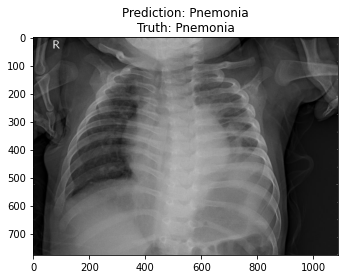

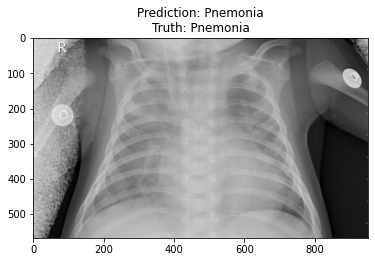

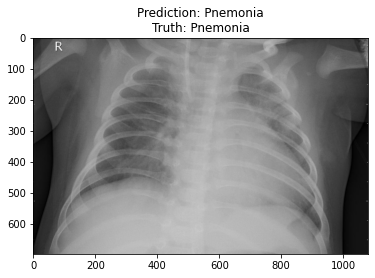

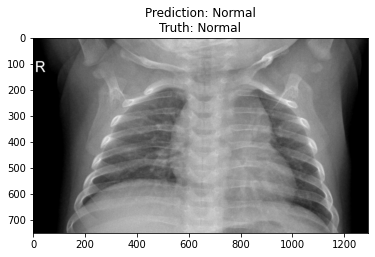

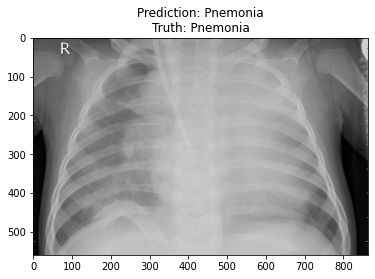

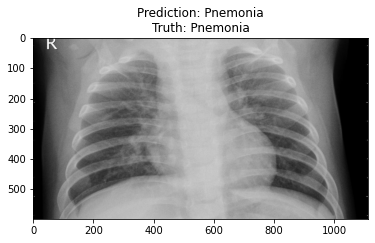

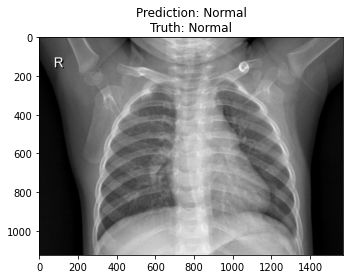

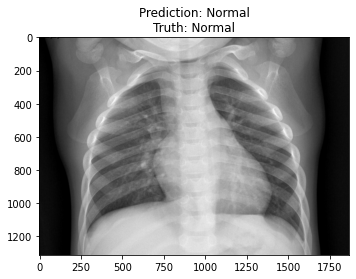

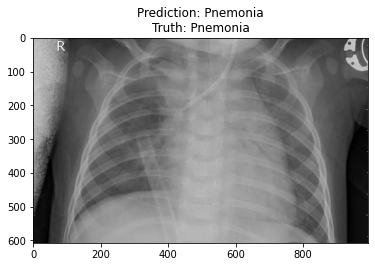

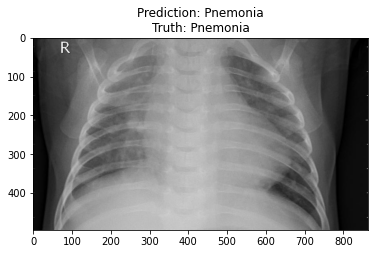

In [29]:
test_images = os.listdir(test_dataset_path)
test_dataset_length = len(test_images)

# load metadata for truth values
metadata_path = os.path.join(root, 'Chest_xray_Corona_Metadata.csv') 
df_metadata = pd.read_csv(metadata_path)

# how many test images you want to see?
num_samples = 10
cols = 3
rows = (num_samples // cols) + 1
see_image = True

#fig, axarr = plt.subplots(rows, cols)

for i in range(num_samples):
    random_idx = random.randrange(0, test_dataset_length)
    img_path = os.path.join(test_dataset_path, test_images[random_idx])
    img = Image.open(img_path).convert('RGB')

    # feed to model
    with torch.no_grad():
        transformations = get_transform(train=False)
        img_transformed = transformations(img)
        outputs = model(img_transformed.unsqueeze(0).to(device))
        _, prediction = torch.max(outputs, 1)
        predicted_label = id_label_map[int(prediction)]

    if see_image:
        plt.imshow(img)
        truth = df_metadata[df_metadata['X_ray_image_name'] == test_images[random_idx]]['Label'].iloc[0]
        plt.title(f'Prediction: {predicted_label}\nTruth: {truth}')
        plt.show()